In [2]:
from src.setup import *
from src import host
from src import common
from src import viral_seq
from Pyhattan import FormatData, GenerateManhattan

%load_ext autoreload
%autoreload 2

# Introduction

In this notebook, we'll do a complete genome-to-genome (G2G) analysis from strach, i.e. beginning with the raw, dirty data, and focus on asian individuals. The principle is to re-run all quality control steps to get a **new dataset** that is not biased by individuals that won't be included in the study. For instance, minor allele frequency (MAF) filtering can be biased when subpopulations with different allele frequencies are present. We also want to avoid such biases with missing values and chromosomes, for example. 

The path to the clean dataset for this study is defined by `PATH_ASIANS_GWAS`.

###### Aim

In this notebook, we create a new dataset that is ready-to-use for downstream analyses and we set up relevant functions to perform a complete G2G analysis (i.e. with all amino acids). To do so, we first run a G2G analysis with two different amino acids, and we do the same for a set of random predictors.

###### Selection of individuals

The clustering that was done in the previous notebook did not provide any satisfying result. Thus we will use a list of individuals that belong to a same cluster, according to the same clustering algorithm (hierarchichal, ward) but done with R (thanks to Sina for providing me the list). This list is specified by `PATH_CLUSTERING_ASIANS`.

###### Plan

1. QC preparation: Exclude variants with 100% missing rate, remove unrelevant chromosomes, keep only relevant individuals, create new (dirty) dataset.
1. Quality control
    1. Missing values (variants), create intermediate dataset
    1. Missing values (individuals), create missingness-treated dataset
    1. MAF filtering, HWE tests, create clean dataset
1. GWAS preparation
    1. Host data PCA
    1. Viral data PCA
    1. Merge all covariates into a plink file
1. Association analyses
    1. Monovariate models
    1. Multivariate models
        * 2 amino acids
        * random predictors

We want to force the order of missingness filtering (first variants, then individuals, i.e. unlike plink does when both commands are run at the same time), thus we create an intermediate dataset after the filtering of missing variants.

# Preparation

At the end of this section, we create a new dataset that is ready for **unbiased** quality control. The filters here are :

* Remove variants with 100% missingness
* Keep only autosomes
* Keep only asian related individuals (a cluster)

In [2]:
# Define the path for this new dataset
path_prepared_dataset = PATH_PLINK_DATA+"asians_gwas_prepared"

In [3]:
# 1. Remove variants with 100% missing rate
host.run_plink("--geno 0.999999999 " + DEFAULT_CHROMOSOME_EXCLUSION_GWAS + \
               " --keep " + PATH_CLUSTERING_ASIANS + " --make-bed",
               file=PATH_HOST_RAW_PLINK_DATA, out=path_prepared_dataset, extension='bed',
               log_name='asians_gwas_0_data_preparation');

Running 'plink2 --bfile data/raw/wes_plink/hbv_gilead_bcftools --out data/plink/asians_gwas_prepared --geno 0.999999999 --not-chr 0 X Y XY MT --keep data/clustering_asians_gwas.txt --make-bed '
Log written to 'data/plink/log/asians_gwas_0_data_preparation.log'


# Quality control

We start the QC with he dataset defined by `path_prepared_dataset`.

###### Missing report



Running 'plink2 --bfile data/plink/asians_gwas_prepared --out data/plink/asians_gwas_prepared --missing '
Log written to 'data/plink/log/asians_gwas_1_missing.log'


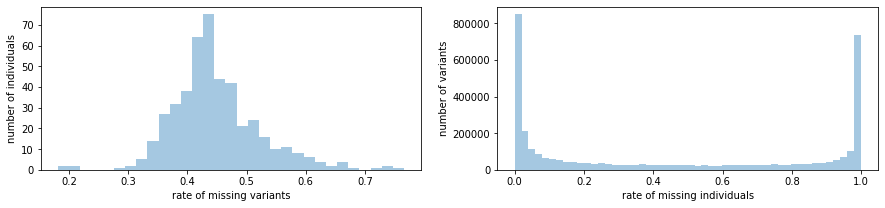

In [4]:
host.run_plink("--missing", file=path_prepared_dataset, out=path_prepared_dataset, 
               extension='vmiss', log_name='asians_gwas_1_missing')
common.plot_missing(path_prepared_dataset)

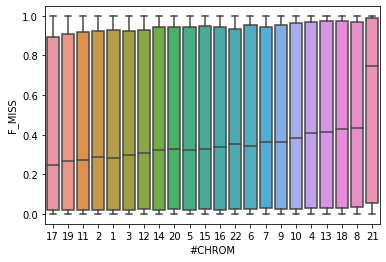

In [5]:
dtype = {'F_MISS':float, 'ID':str, '#CHROM':str}
df_miss_var = pd.read_csv(path_prepared_dataset+'.vmiss', sep='\s+', usecols=['#CHROM', 'ID', 'F_MISS'], dtype=dtype)
df_miss_chr = df_miss_var.groupby('#CHROM').mean()
sns.boxplot(x='#CHROM', y='F_MISS', data=df_miss_var, order=df_miss_chr.sort_values(by='F_MISS').index);

###### Filter variants

In [6]:
# 1. Path for this intermediate dataset
path_intermed_dataset = PATH_PLINK_DATA+"asians_gwas_intermed_QC"

In [7]:
# 2. Filter
host.run_plink("--geno " + str(THRESHOLD_MISSING_VARIANTS) + " --make-bed", file=path_prepared_dataset,
              out=path_intermed_dataset, extension='bed', log_name='asians_gwas_2_intermedQC');

Running 'plink2 --bfile data/plink/asians_gwas_prepared --out data/plink/asians_gwas_intermed_QC --geno 0.1 --make-bed '
Log written to 'data/plink/log/asians_gwas_2_intermedQC.log'


###### Filter individuals

In [8]:
path_missingness_treated_dataset = PATH_PLINK_DATA+"asians_gwas_missingness_treated"

In [9]:
host.run_plink("--mind " + str(THRESHOLD_MISSING_INDIVIDUALS) + " --make-bed", file=path_intermed_dataset,
              out=path_missingness_treated_dataset, extension='bed', log_name='asians_gwas_3_miss_treated');

Running 'plink2 --bfile data/plink/asians_gwas_intermed_QC --out data/plink/asians_gwas_missingness_treated --mind 0.1 --make-bed '
Log written to 'data/plink/log/asians_gwas_3_miss_treated.log'


###### Missing report of missingness treated dataset

Running 'plink2 --bfile data/plink/asians_gwas_missingness_treated --out data/plink/asians_gwas_missingness_treated --missing '
Log written to 'data/plink/log/asians_gwas_4_missing.log'


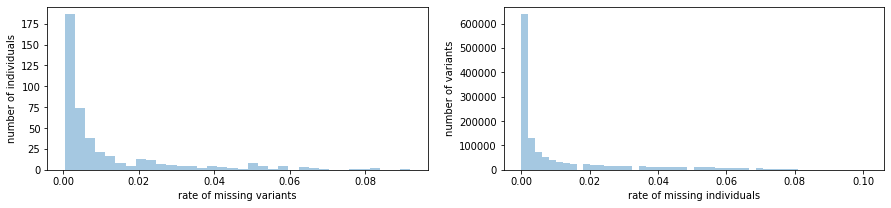

In [10]:
host.run_plink("--missing", file=path_missingness_treated_dataset, out=path_missingness_treated_dataset, 
               extension='vmiss', log_name='asians_gwas_4_missing')
common.plot_missing(path_missingness_treated_dataset)

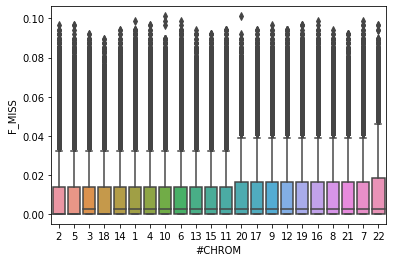

In [11]:
dtype = {'F_MISS':float, 'ID':str, '#CHROM':str}
df_miss_var = pd.read_csv(path_missingness_treated_dataset+'.vmiss', sep='\s+', usecols=['#CHROM', 'ID', 'F_MISS'], dtype=dtype)
df_miss_chr = df_miss_var.groupby('#CHROM').mean()
sns.boxplot(x='#CHROM', y='F_MISS', data=df_miss_var, order=df_miss_chr.sort_values(by='F_MISS').index);

###### MAF and HWE

This is the last step of QC, the datset will be ready for association analyses.

In [26]:
o, e = host.run_plink("--maf "+str(THRESHOLD_MAF)+" --hwe "+str(THRESHOLD_HWE)+" --make-bed", 
               file=path_missingness_treated_dataset, extension='bed',
              out=PATH_ASIANS_GWAS, log_name='asians_gwas_5_maf_hwe');

Running 'plink2 --bfile data/plink/asians_gwas_missingness_treated --out data/plink/asians_gwas --maf 0.05 --hwe 1e-06 --make-bed '
--geno, and/or applying different p-value thresholds to distinct subsets of
your data.



***
# Association analyses

## Monovariate model

Here the predictor is the genotype of each individual.

434 individuals written to 'data/working_pheno'
0 were filtered out based on the criteria None
The phenotype '('S', 35, 'R')' were included from clinical data.
Running 'plink2 --bfile data/plink/asians_gwas --out data/plink/gwas/asians_gwas --1 --logistic --pheno data/working_pheno --keep data/working_pheno --pheno-name S_35_R '
Log written to 'data/plink/log/assoc.log'


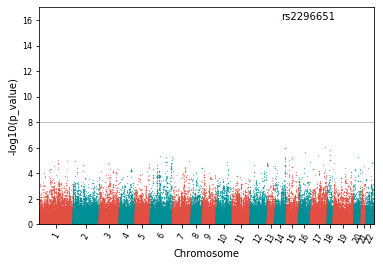

In [29]:
common.write_phenotypes(PATH_ASIANS_GWAS, phenotype=('S', 35, 'R'), output_path=PATH_WORKING_PHENOTYPES)
o, e = host.run_gwas(use_pheno="S_35_R", path_covariates=None, path_phenotypes=PATH_WORKING_PHENOTYPES);
# No covariates, phenotype is WORKING_PHENOTYPE
data = FormatData(PATH_ASIANS_GWAS_RESULTS+'.S_35_R.glm.logistic', sep='\s+', chromosome='#CHROM', 
                  p_value='P')
GenerateManhattan(data, refSNP='ID', significance=8)

434 individuals written to 'data/working_pheno'
0 were filtered out based on the criteria None
The phenotype '('PC', 160, 'A')' were included from clinical data.
Running 'plink2 --bfile data/plink/asians_gwas --out data/plink/gwas/asians_gwas --1 --logistic --pheno data/working_pheno --keep data/working_pheno --pheno-name PC_160_A '
Log written to 'data/plink/log/assoc.log'


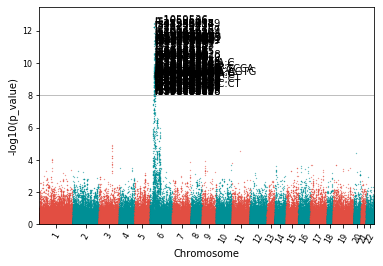

In [30]:
# Here we simply overwrite on the phenotype S_35_R
common.write_phenotypes(PATH_ASIANS_GWAS, phenotype=('PC', 160, 'A'), output_path=PATH_WORKING_PHENOTYPES)
o, e = host.run_gwas(use_pheno="PC_160_A", path_covariates=None, path_phenotypes=PATH_WORKING_PHENOTYPES);
# No covariates, phenotype is WORKING_PHENOTYPE
data = FormatData(PATH_ASIANS_GWAS_RESULTS+'.PC_160_A.glm.logistic', sep='\s+', chromosome='#CHROM', 
                  p_value='P')
GenerateManhattan(data, refSNP='ID', significance=8)

***
# Multivariate association model


###### Model

The response variable is the presence or absence of a viral amino acid mutation. Thus, we use a generalized linear model (GLM) for a binary response variable, i.e. a logistic regression model. It can be written as:


This is not true (think again about it): $ logit(y_k) = G\beta_k + X\alpha_k + \epsilon_k$, $1 \leq k \leq N$

$ \Large logit(\vec y_i) = \vec \beta_{ij} \vec G_j + \vec\alpha_{ij} X + \vec\epsilon_{ij} $, $1 \leq j \leq M$, $1 \leq i \leq N$

Where 

* $M$ is the number of human polymorphisms
* $N$ is the number of amino acids
* $\vec y_i$ is a column vector of binaries representing mutations of amino acid $i$
* $\vec \beta_{ij}$ is a row vector containing coefficients for amino acid $i$ and SNP $j$
* $\vec G_j$ is a column vector representing the host genotypes for the SNP $j$
* $X$ is a fixed design matrix containing covariates (age, sex, PCs of viral data, PCs of host data)
* $\vec \epsilon_{ij}$ is a column vector of independent and identically distributed random variables, such that $\epsilon_{ij} \sim N(0, \sigma_j)$

###### Assumptions

* The Hardy-Weinberg assumptions hold

[quote](https://link.springer.com/protocol/10.1007%2F978-1-62703-447-0_6):
> In a random mating population with no population structure, the association between a marker and a trait can be tested with single marker regression as ...

###### Hypothesis tests

Each statistical test that is performed on an amino acid $i$ and a SNP $j$ is as the following:

1. Parameter: $\vec \beta_{ij}$
1. $H_0:\vec \beta_{ij} = \vec 0$, the genetic marker $j$ has no effect on amino acid $i$vs <br />$A: \vec \beta_{ij} \neq \vec 0$
1. Test statistic: Wald test, $z_{obs} = \frac{\hat \beta}{\widehat{SE(\beta)}}$
1. Under $H_0$, $z_{obs} \sim N(0, 1)$

###### Plink implementation

From [plink doc](https://www.cog-genomics.org/plink/1.9/input#covar):

> `--covar` designates the file to load covariates from. The file format is the same as for --pheno. The main phenotype is no longer set to missing when a covariate value is missing; instead, this only happens to the temporary phenotype copies used by e.g. the linear/logistic regression routine.
>
>Categorical covariates are now directly supported. Any nonnumeric string ('NA' and 'nan' are considered to be numbers for this purpose) is treated as a categorical covariate name.
>
>`--covar-name` works like --pheno-name. It can now be used without --covar (in which case the --pheno or .psam file is the target).
>
>`--covar-col-nums` works like --pheno-col-nums, and refers to the --pheno file when --covar is not specified.
>
>When no primary header line is present, covariates are assigned the names 'COVAR1', 'COVAR2', etc.

We'll use the `write_covariates` together with `write_phenotypes` to write the predictors, covariates and response variables. Since the covariates file format is very similar to the phenotypes file format, the function writing covariates itself calls the function that writes phenotypes.

We will write all amino acids in the phenotype file and plink will automatically loop over each amino acid. Thus we end up with N association tables (N = number of viral amino acid) that we will filter for significant associations.

***
## Covariates

We want to include age, sex, host principal components and viral principal components as covariates. We need to re-compute all principal components since the subset of individuals has changed (thus the PCs change). This is fairly easy for the host data (we use plink), but it requires a bit of data processing for the viral data (must map the ids between different datasets).

#### Compute PCs of the new dataset

We must remove chromosome 6 from the PCA since it is known to disrupt the PCA.

###### Host data

In [43]:
host.run_plink("--pca "+str(GWAS_HOST_NUMBER_PCS)+" --not-chr 6", file=PATH_ASIANS_GWAS, out=PATH_ASIANS_GWAS, extension='eigenval',
              log_name='asians_gwas_6_pca');

Running 'plink2 --bfile data/plink/asians_gwas --out data/plink/asians_gwas --pca 4 --not-chr 6 '
Log written to 'data/plink/log/asians_gwas_6_pca.log'


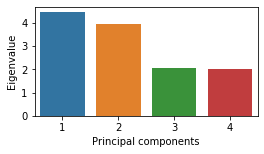

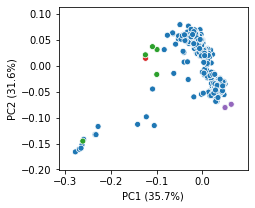

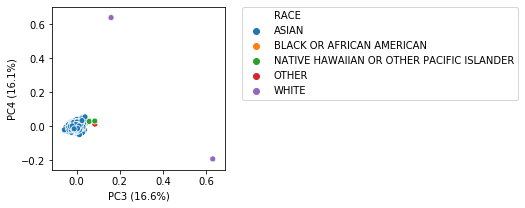

In [11]:
# Visualize
host.plot_plink_pca(PATH_ASIANS_GWAS, n_pcs = 4, hue_col='RACE', bbox_to_anchor=(1.1,1))

###### Viral data

We recompute the PCs of viral data by selecting only the current subset of individuals. We need to include IDs to allow `write_covariates` to join those PCs with the other covariates. This requires a few lines of code since we must join datasets with different ids (GS and IGM).

In [44]:
# 1. Load viral data
with open(PATH_VIRAL_DATA, 'rb') as file:
    df = pickle.load(file)
df.set_index((ID_GS_VIRAL_DF, '', ''), inplace=True)

In [45]:
# 2. Load list of intersecting IDs
df_ids = common.write_phenotypes(fam=PATH_ASIANS_GWAS, verbose=True) # this only provides IDs (no phenotype)
# 3. Map GS ids to IGM ids
df_ids['GS'] = common.map_ids(df_ids.IID) 
# 4. Prepare DataFrame for joining with viral data
df_ids.drop('FID', inplace=True, axis=1)
df_ids.set_index('GS', inplace=True)
df_ids.columns = pd.MultiIndex.from_product([ ['IID'], [''], [''] ]) # required for joining

434 individuals written to 'None'
0 were filtered out based on the criteria None
The phenotype 'None' were included from clinical data.


In [46]:
# 3. Join the ids with the viral data (thus exclude ids that are only in viral data)
# This works since df_ids contains the intersection of all ids, computed by write_phenotypes
# See the pandas documentation on how DataFrame.join() works
df_viral_pca = df_ids.join(other=df)
_, data = viral_seq.pca_impute(df_viral_pca.drop(('IID', '', ''), axis=1), n_components=6, 
                                 impute_strategy='most_frequent')
df_viral_pca.set_index('IID', inplace=True)
df_pcs = pd.DataFrame(index=df_viral_pca.index, data=data)
df_pcs.columns = [ 'VPC'+str(i+1) for i in range(df_pcs.shape[1]) ] # rename columns
df_pcs.shape

(434, 6)

#### Write the covariates

Now we'll use the `write_covariates` function. We provide the following parameters:

* fam: *path* to the plink dataset 
* host_pcs: *path* to the plink '.eigenvec' file
* virus_pcs: DataFrame *object* containing the PCs of viral data

In [47]:
common.write_covariates(fam=PATH_ASIANS_GWAS, host_pcs=PATH_ASIANS_GWAS+'.eigenvec',
                       virus_pcs=df_pcs, output_path=PATH_ASIANS_GWAS_COVARIATES)

434 individuals written to 'None'
0 were filtered out based on the criteria None
The covariates '['AGE', 'SEX']' were included from clinical data.
4 host PCs and 6 viral PCs were included as covariates
A total of 12 covariates were written in data/covariates_asians_gwas.txt


***
## Phenotypes

We must now tune the `write_phenotypes` a little bit, to make it write **all amino acids at once** in the file. We basically add the possibility to set `phenotype='all'`. 

To handle Na values, we set `PLINK_PHENOTYPE_NA_REP = "NA"` since this is the default value interpreted as missing by plink (see [doc](https://www.cog-genomics.org/plink/1.9/input)), and we use this value as a parameter when using `DataFrame.to_csv()` (by default, pandas writes empty strings).

In [5]:
common.write_phenotypes(PATH_ASIANS_GWAS, phenotype='all', output_path=PATH_ASIANS_GWAS_PHENOTYPES)

434 individuals written to 'data/phenotypes_asians_gwas.txt'
0 were filtered out based on the criteria None
The phenotype 'all' were included from viral data.


***
## Run associations

At this point, we have two files containing the phenotypes (viral amino acid mutations) and the covariates (age, sex, principal components). Here, we will run the association for only two amino acids, and a random predictor. All amino acids are tested in the next notebook *G2G computer*.

###### Methods

We will use the custom function `run_gwas`, which calls `run_assoc`, which itself calls `run_plink`. Each upstream function defines parameters that are useful in its context. Basically, we can do two things with `run_gwas`:

* Run a G2G analysis with a given list of amino acids
* Run many G2G studies with all amino acids written in the phenotype file. 

The first option makes nothing special, excepting setting the right parameters. However, the second option requires the `run_gwas` function to be optimized given the huge amount of data that is generated (about 90GB). Thus, the following features are implemented: 

* We don't let plink to loop over all phenotypes, we detect the columns of the phenotype file manually, and call `run_assoc` for each amino acid manually (advantage: keep track of what's happening).
* We actually do this in a **recursive manner**: we run a loop in `run_gwas` which calls itself at each step (but asks to test a single amino acid...).
* We store the results in a temporary directory (`setup.PATH_ASIANS_GWAS_TMP_RESULTS`), i.e. in our case the `/scratch` directory. 
* After each association done for a specific amino acid, we filter out the output with a *very* tolerant p-value threshold (the huge majority of tests have $p>10^{-2}$).
* From all the outputs that were filtered, we add the remaining data in a new table. This table is the same as the one provided by plink, with an extra column that specifies the amino acids that was tested.

In [58]:
# QQ-plot function: expected vs observed p-values (-log10 transformation)
def plot_QQ(pvals, title, ax=None):
    # Transformation
    minlog10 = -np.log10(pvals)
    # Expected uniform distrib
    uniform_grid = np.linspace(0, 1, len(minlog10))
    # Avoid error of division by 0 -> exclude 0, thus drop an element of the other list to keep same size
    if ax==None:
        plt.scatter(x= -np.log10(uniform_grid[1:]), y=sorted(minlog10, reverse=True)[0:-1])
    else:
        ax.scatter(x= -np.log10(uniform_grid[1:]), y=sorted(minlog10, reverse=True)[0:-1])
    plt.xlabel('Theoretical value'); plt.ylabel('-log10(p)')
    plt.title(title)

In [49]:
o, e = host.run_gwas(use_pheno='S_35_R')

Running 'plink2 --bfile data/plink/asians_gwas --out data/plink/gwas/asians_gwas --1 --logistic --pheno data/phenotypes_asians_gwas.txt --keep data/phenotypes_asians_gwas.txt --covar data/covariates_asians_gwas.txt --pheno-name S_35_R '
phenotype 'S_35_R'.

Log written to 'data/plink/log/assoc.log'


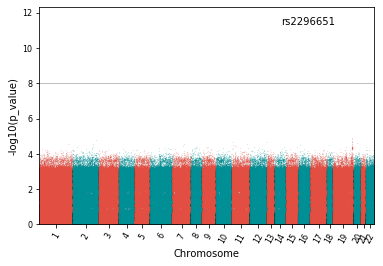

In [53]:
data = FormatData(PATH_ASIANS_GWAS_RESULTS+".S_35_R.glm.logistic", sep='\s+', chromosome='#CHROM', 
                  p_value='P')
GenerateManhattan(data, refSNP='ID', significance=8)

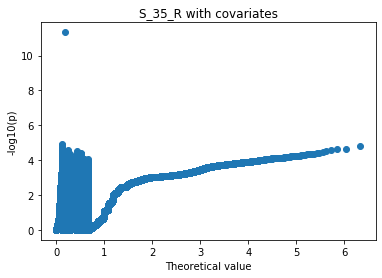

In [70]:
plot_QQ(pd.read_csv(PATH_ASIANS_GWAS_RESULTS+".S_35_R.glm.logistic", sep='\t',
                    usecols=['P'], dtype={'P':float}).P, 'S_35_R with covariates')

Running 'plink2 --bfile data/plink/asians_gwas --out data/plink/gwas/asians_gwas --1 --logistic --pheno data/phenotypes_asians_gwas.txt --keep data/phenotypes_asians_gwas.txt --covar data/covariates_asians_gwas.txt --pheno-name PC_160_A '
phenotype 'PC_160_A'.

Log written to 'data/plink/log/assoc.log'


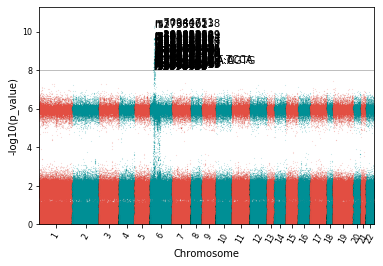

In [57]:
o, e = host.run_gwas(use_pheno='PC_160_A')
data = FormatData(PATH_ASIANS_GWAS_RESULTS+".PC_160_A.glm.logistic", sep='\s+', chromosome='#CHROM', 
                  p_value='P')
GenerateManhattan(data, refSNP='ID', significance=8)

## Random predictor


In [22]:
common.write_phenotypes(PATH_ASIANS_GWAS, phenotype='random', output_path=PATH_WORKING_PHENOTYPES)

434 individuals written to 'data/working_pheno'
0 were filtered out based on the criteria None
The phenotype 'random' were included from clinical data.


In [23]:
o, e = host.run_assoc(phenotypes=PATH_WORKING_PHENOTYPES, exclude_chrs=None, 
                     file=PATH_ASIANS_GWAS, out=PATH_ASIANS_GWAS_RAND,
                     covariates=PATH_ASIANS_GWAS_COVARIATES)

Running 'plink2 --bfile data/plink/asians_gwas --out data/plink/gwas/asians_gwas_random --linear --pheno data/working_pheno --keep data/working_pheno --covar data/covariates_asians_gwas.txt '
Log written to 'data/plink/log/assoc.log'


In [24]:
# 1. Load the list of p-values (additive effects only)
p_list = []
for i in range(10): # 10 random predictors generated by write_phenotypes
    df = pd.read_csv(PATH_ASIANS_GWAS_RAND+'.'+str(i+1)+'.glm.linear', sep='\t')
    p_list.append(df[ df.TEST == 'ADD' ].P)
df = None

/home/mazeller/.local/lib/python3.6/site-packages/assocplots/qqplot.py:60: RuntimeWarning: invalid value encountered in less
  q_err[i, q_err[i, :] < 0] = 1e-15
/home/mazeller/.local/lib/python3.6/site-packages/assocplots/qqplot.py:69: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log10(q_th[:n_quantiles]), -np.log10(q_data[:n_quantiles]), '.', color=color[j], label=labels[j])
/home/mazeller/.local/lib/python3.6/site-packages/assocplots/qqplot.py:78: RuntimeWarning: divide by zero encountered in log10
  plt.fill_between(-np.log10(q_th), -np.log10(q_err[:,0]), -np.log10(q_err[:,1]), color=color[j], alpha=fill_dens[j], label='%1.3f CI'%alpha)


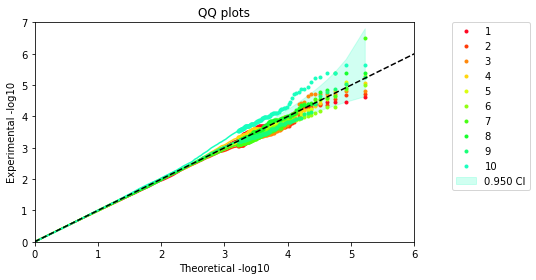

In [25]:
from assocplots.qqplot import *
colors = ['#FF0521', '#FF3907', '#FF8809', '#FFD60C', '#DBFF0E', '#90FF10', '#47FF12', '#15FF2B', '#17FF76', '#19FFBF']
names = [ str(i+1) for i in range(10) ]
fill_dens = [0.2] * len(p_list)
qqplot(p_list, 
   names, 
   color=colors, 
   fill_dens=fill_dens, 
   error_type='theoretical', 
   distribution='beta',
   title='QQ plot of background associations')
plt.gca().legend(bbox_to_anchor=(1.1,0.1*len(p_list)), loc=2, borderaxespad=0.);